## Отбор эталонных объектов

Пусть:  
$u$ - Выбранный для классификации объект  
$y$ - класс  

Оценка близости объекта `u` к классу `y`
$$\Gamma_y(u)=\sum_{i=1}^{l}[y^{(i)}_u=y]w(i,u)$$ 

Чтобы поделить данные вводится понятие - отступа - величины, которая расчитывается по формуле:
$$M(x_i)=\Gamma_{y_i}(x_i)-\max_{y \in Y\setminus y_i}\Gamma_y(x_i)$$ 

Отступ показывает степень типичности объекта. Отступ отрицателен тогда
и только тогда, когда алгоритм допускает ошибку на данном объекте.

Распределение значений отступов в выборке даёт полезную дополнительную
информацию не только об отдельных объектах, но и о выборке в целом. Если основ-
ная масса объектов имеет положительные отступы, то разделение выборки можно
считать успешным. Если в выборке слишком много отрицательных отступов, то ги-
потеза компактности не выполняется, и в данной задаче при выбранной метрике
применять алгоритмы типа kNN нецелесообразно.


Возьмем тестовые данные

In [1]:
% reload_ext autoreload
% autoreload 2

from __future__ import absolute_import
import data_preparing as dp

% matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

mpl.style.use('classic')

distributed_samples['data','target']


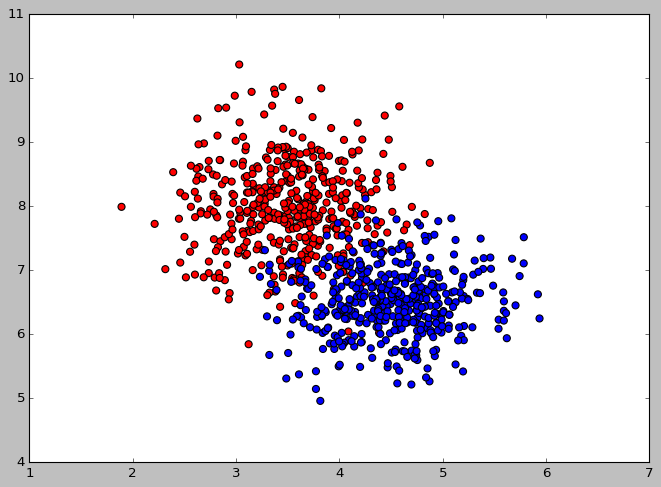

In [2]:
import pandas as pd
from matplotlib.colors import ListedColormap

part_size = 450

dataset = np.vstack([
    np.hstack([
        dp.get_normal_distributed_features(2,5,6,10, part_size), 
        np.full((part_size,1),0)]
    ),
    np.hstack([
        dp.get_normal_distributed_features(3,6,5,8,  part_size), 
        np.full((part_size,1),1)]
    ),
])

distributed_samples = {
    'data':dataset[:,:2],
    'target':dataset[:,2]
}

print("distributed_samples['data','target']")

plt.figure(figsize=(10,7))

plt.scatter(
    x=dataset[:,0],
    y=dataset[:,1], 
    c=dataset[:,2],
    cmap=ListedColormap(['#FF0000', '#00FF00', '#0000FF']),
    s=40
)

plt.show();

Оценка близости в нашем случае (к ближайших соседей) будет - сумма расстояний до ближайших соседей выбранного класса.

In [3]:
n_neighbors = 20

# Графики точек каждого из типов 
types = pd.DataFrame([
    {
        'title': "Шумовые",
        'start': 0,
        'finish': 40
    },
    {
        'title': "Неинформативные",
        'start': 40,
        'finish': 700
    },
    {
        'title': "Эталонные",
        'start': 700,
        'finish': 900
    }]
)

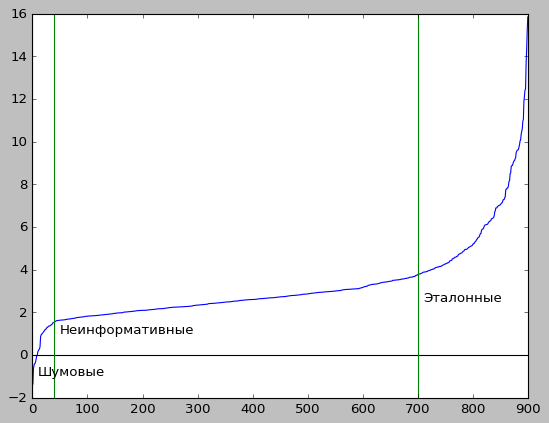

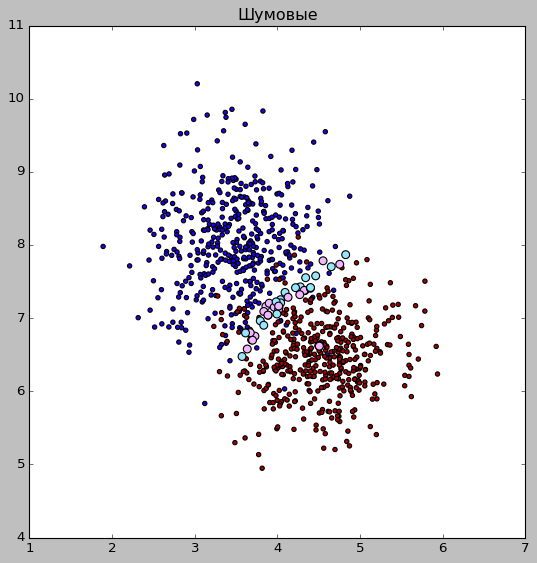

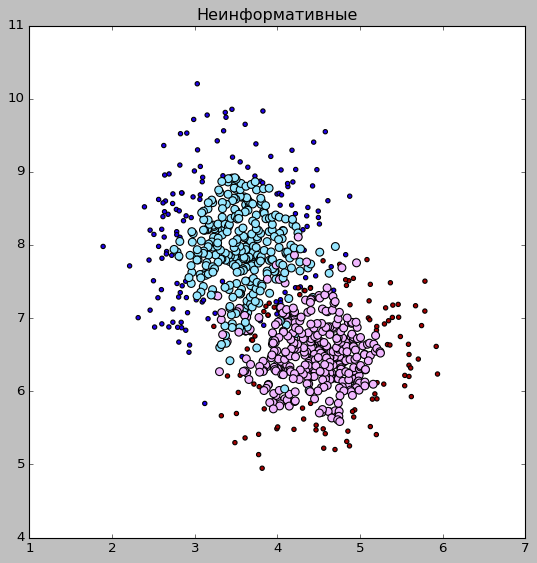

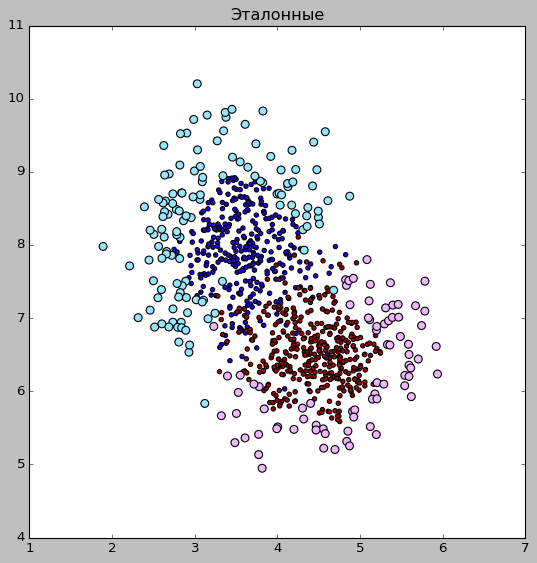

In [4]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from IPython.core.debugger import set_trace
import pandas as pd

data = distributed_samples['data']
target = distributed_samples['target']

# ====================

nbrs = KNeighborsClassifier(n_neighbors=n_neighbors).fit(
    data, 
    target
)

model_classes = nbrs.predict(data)
distances, indices = nbrs.kneighbors(data, return_distance=True)

ident = np.zeros(data.shape[0])
classes = np.unique(target)

for ni in range(data.shape[0]):

    distsum = np.zeros(len(classes))
    for ci in range(len(classes)):
#         Классы этого ряда индексов indices
        indcls = model_classes[indices[ni]]
#        Маска тех значений классы которых равны текущему 
#           (indcls) = (classes[ci])
        mask = indcls==classes[ci]
#     Сумма дистанций соответсвующего класса
        distsum[ci] = np.sum(distances[ni][mask])
        
    sortdistindx = np.flip(np.argsort(distsum), axis=0)
    if model_classes[ni] == classes[sortdistindx[0]]:
        closestdist = distsum[sortdistindx[1]]
        selfdist = distsum[sortdistindx[0]]
    else:
        closestdist = distsum[sortdistindx[0]]
        selfdist = distsum[classes==model_classes[ni]]
        
    ident[ni] = selfdist - closestdist
    
    
# График отступов по порядку возрастания
plt.figure()

identsortind = np.argsort(ident)
plt.plot(ident[identsortind]);
plt.axhline(0, color='black');

#  ----
for index, series in types.iterrows():
    plt.axvline(series.start, color='green');
    plt.text(
        s=series.title,
        x=series.start+10,
        y=ident[identsortind][series.start]/1.5
    )

for index, series in types.iterrows():
    plt.figure(figsize=(8,8))
    plt.title(series.title)
    
#     Все данные
    plt.scatter(
        data[:,0],
        data[:,1],
        c=target,
        cmap = ListedColormap(['#1f00ed', '#a50101']),
        s = 15
    )
    
#     выбранный тип точек
    ind = identsortind[series.start:series.finish]
    plt.scatter(
        data[ind,0], 
        data[ind,1],
        c=target[ind],
        cmap = ListedColormap(['#96e6ff', '#f0b7ff']),
        s=50
    );

    

#  ----